In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_circles
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook as tqdm
from jupyterthemes import jtplot
from sklearn.datasets import make_classification
# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()
%matplotlib inline

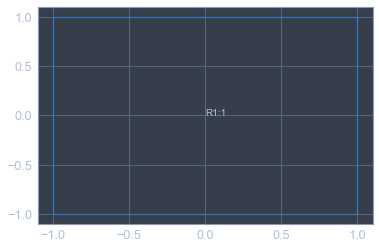

In [18]:
def rectangle_plot(u,v, region_index=None, label=None):
    v = 1-v
    midpoint = (u+v)/2
    # lower left
    ll_vertex = u.flatten()
    # upper left 
    ul_vertex = np.array([ u[0], v[1] ])
    #upper right
    ur_vertex = v.flatten()
    #lower right
    lr_vertex = np.array([v[0], u[1]])
    d = {0:'r', 1:'b'}
    cc =d[label] 
    
    plt.plot( [ul_vertex[0],ur_vertex[0] ] , [ul_vertex[1],ur_vertex[1] ], c=cc)
    plt.plot( [ll_vertex[0],ul_vertex[0] ] , [ll_vertex[1],ul_vertex[1] ], c=cc)
    plt.plot( [ll_vertex[0],lr_vertex[0] ] , [ll_vertex[1],lr_vertex[1] ], c=cc)
    plt.plot( [ur_vertex[0],lr_vertex[0] ] , [ur_vertex[1],lr_vertex[1] ], c=cc)
    if region_index :
        plt.annotate('R{}:{}'.format(region_index, label), xy=(midpoint[0], midpoint[1]), )
        
rectangle_plot(np.array([1,1]), np.array([2,2]), 1,1)
                                              

In [19]:
test = np.array([[1,2,3,4]]).T
test2 = np.array([[.5,1.5,3.5,4.1]]).T
t = np.hstack((test,test2))
np.minimum(test, test2)

array([[0.5],
       [1.5],
       [3. ],
       [4. ]])

In [20]:
t

array([[1. , 0.5],
       [2. , 1.5],
       [3. , 3.5],
       [4. , 4.1]])

In [21]:
df = pd.DataFrame(t, columns=['W0', 'W1'])
df

,W0,W1
0,1.0,0.5
1,2.0,1.5
2,3.0,3.5
3,4.0,4.1


In [22]:
test_vec = np.array([[1,1,3,1]]).T
test_vec

array([[1],
       [1],
       [3],
       [1]])

In [23]:
#laplacian_kernel(df.T ,test_vec.T).T

In [24]:
# apply fuzzy intersection element wise. 
fuzzy_int = np.minimum(test_vec,df)
fuzzy_int = np.linalg.norm( fuzzy_int, ord=1, axis=0)

In [25]:
np.linalg.norm( df, ord=1, axis=0)

array([10. ,  9.6])

In [26]:
#scale(test)

In [27]:

np.minimum(t, test)

array([[1. , 0.5],
       [2. , 1.5],
       [3. , 3. ],
       [4. , 4. ]])

In [28]:
np.sum(t, axis=1)

array([1.5, 3.5, 6.5, 8.1])

In [29]:
np.argmin(np.sum(np.minimum(t,test), axis=1))

0

In [161]:
#l1_norm = partial(np.linalg.norm, ord=1, axis=-1)
class FuzzyARTMAP:
    def __init__(self,  alpha=0.01, beta=1.0, rho=0., epsilon=0.0001, complement_coding=True, norm=1):
        """
        alpha: matching parameter
        beta: learning rate
        rho: Vigilence criterion

        """
        self.alpha = alpha
        self.beta = beta
        self.baseline_rho = rho
        self.rho = rho
        self.epsilon=epsilon
        self.complement_coding= complement_coding
        self.w = None
        self.w_labels = {}
        # there are no commited nodes
        self.C= -1
        self.M = None
        self.norm=1
    
    def complement_code(self, x):
        """Utility function for compliment coding of inputs"""
        if self.complement_coding:
            return np.vstack((x, 1-x))
        else:
            return x
        
    def add_category(self,x, y_label):
        """Adds an additional weight vectot w of class y """# 
        # use the weight as the examplar 
        self.C +=1
        
        self.w["W{}".format(self.C)]  =  x
        # save category label 
        self.w_labels["W{}".format(self.C)] = np.squeeze(y_label)
        
    def match_choice(self, x):
        norm_w =  np.linalg.norm( self.w, ord=self.norm, axis=0)
        fuzzy_int = np.minimum(x,self.w)
        fuzzy_int = np.linalg.norm( fuzzy_int, ord=self.norm, axis=0)
        # all values of T_j for j=1,...,C
        #T_js = fuzzy_int + (1 - self.alpha)*(self.M * norm_w)
        T_js = fuzzy_int / (self.alpha + norm_w)
        T_js_bools = T_js > self.alpha * self.M
        T_js = np.multiply(T_js, T_js_bools).reshape(T_js.shape)
        vig = fuzzy_int >= self.M * self.rho
        indicies = sorted(range(len(T_js)), key=lambda k: T_js[k], reverse=True)
        return T_js, vig, indicies, fuzzy_int, norm_w
                          
                          
    
    
    def train(self, X, y, epochs = 1, s=np.inf):
        """number of examples x number of features"""
        # initialize first weight 
        self.C = 0
        x_init = self.complement_code(X[:,0].reshape(-1,1))
        self.M = np.squeeze(X.shape[0])
        print(x_init)
        self.w = pd.DataFrame(np.ones( ( x_init.shape[0],1)), columns=["W{}".format(self.C)])
        # initialize first class
        self.w_labels["W{}".format(self.C)] = np.squeeze(y[0])
        #print(self.w, self.w_labels, X)
        for epoch in tqdm(range(epochs)):
            self.beta*= .95 **epoch 
            perm = np.random.permutation(len(X.T))
            X = X.T[perm].T
            y = y[perm]
            for i in range(X.shape[1]):
                # evaulate match criterion with choice function 
                # T_j is the array of activations
                # vig is a  boolean array determining if the input satisfies the vigilence parameter
                # indicies is the sorted array of indicies
                # fuzzy int is the fuzzy intersection
                #norm_w is the norm o the weight vectors 
                satisfied = False
                # we will go until we are satisfied with a prediction 
                attempts = 0
                self.rho = self.baseline_rho
                A = self.complement_code(X[:,i].reshape(-1,1))
                while not satisfied:
                    attempts +=1
                    #print("Attempts: {}".format(attempts))
                    if attempts > X.shape[1] * 2:
                        print("Large amount of attempts detected: {}".format(attempts))
                    T_js, vig, indicies, fuzzy_int, norm_w = self.match_choice(A)
                    
                    look= True
                    ind = -1
                    while ind < len(list(indicies)) and look:
                        ind +=1
                        index = indicies[ind]
                        if vig[index]:
                            # we have satisfied the vigilence criterion 
                            pred = self.w_labels["W{}".format(index)]
                            if pred != y[i]:
                                # Match tracking for incorrect predictions 
                                #print("Wrong Prediction {}, for ground truth {}. Match tracking enabled.".format(pred, y[i]))
                                self.rho = (fuzzy_int[index]/ self.M) + self.epsilon
                                look=False
                                # we are still not satisfied 
                            else: 
                                # Resonance enabled 
                                #print(" Prediction {}, for ground truth {}. Resonance enabled.".format(pred, y[i]))
                                w_old = self.w["W{}".format(index)].reshape(-1,1)
                                #print("DEBUG:",A.shape, w_old.shape )
                                new_comp =   np.minimum(A, w_old)
                                self.w["W{}".format(index)] = self.beta * ( new_comp) + (1- self.beta)*w_old
                                look = False
                                satisfied = True
                                #print("Updated weight  ", self.w["W{}".format(index)])
                        if ind == len(list(indicies)) -1 and look: 
                            if np.linalg.norm(self.w.values.flatten(), ord=self.norm) <= s:
                                #print("No node found that satisfies Vigilence criterion. Creating a new node")
                                self.add_category(A, y[i])
                            else: # experiment with regularization
                                print("Bandwidth Exceeded. Weights decay ")
                                self.w *= .99
                                self.beta *=.95
                            satisfied=True
                            look=False
                            continue
                            
                                
                
                
                
    def bulk_predict(self, X):
        rets = []
        for i in range(X.shape[1]):
            A = self.complement_code(X[:,i].reshape(-1,1))
            rets +=[self.predict(A)]
        return np.array(rets)
    
    def bulk_transform(self, X):
        rets = []
        for i in range(X.shape[1]):
            A = self.complement_code(X[:,i].reshape(-1,1))
            rets +=[self.T_j_transform(A)]
        return np.array(rets)
    
        
    def T_j_transform(self, x):
        norm_w =  np.linalg.norm( self.w, ord=self.norm, axis=0)
        fuzzy_int = np.minimum(x,self.w)
        fuzzy_int = np.linalg.norm( fuzzy_int, ord=self.norm, axis=0)
        # all values of T_j for j=1,...,C
        T_js = T_js = fuzzy_int / (self.alpha + norm_w)
        pick = weight_index = np.argmax(   T_js )
        p_w = self.w["W{}".format(pick)].values.flatten()
        
        #indicies = sorted(range(len(T_js)), key=lambda k: T_js[k], reverse=True)
        return (p_w[:self.M] +  (1-p_w[self.M:] ))/2 
        
    def predict(self, x):
        norm_w =  np.linalg.norm( self.w, ord=self.norm, axis=0)
        fuzzy_int = np.minimum(x,self.w)
        fuzzy_int = np.linalg.norm( fuzzy_int, ord=self.norm, axis=0)
        T_js = fuzzy_int / (self.alpha + norm_w)
        # all values of T_j for j=1,...,C
        #T_js = fuzzy_int + (1 - self.alpha)*(self.M * norm_w)
        weight_index = np.argmax(   T_js )
        return self.w_labels["W{}".format(weight_index)]
        
        
        

In [162]:
# lets test out some values
np.random.seed(69)
X = np.random.rand( 75,2)

In [163]:
y = ((X[:,0] **2 + X[:,1] **2) <= .4 ).astype(int)

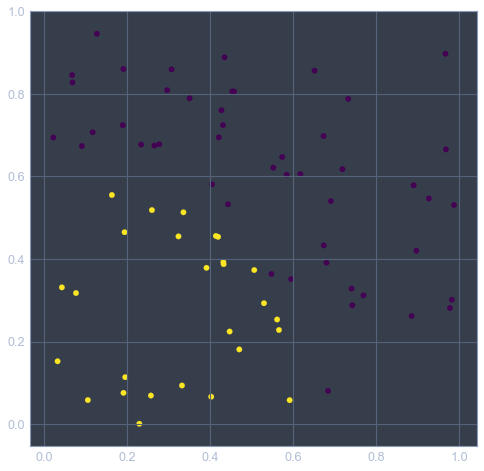

In [164]:
plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], c=y)

In [167]:
net = FuzzyARTMAP(alpha=.1, beta=1)
net.train(X.T,y, epochs=1)

[[0.29624916]
 [0.80906772]
 [0.70375084]
 [0.19093228]]


/Users/kbernardini/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:107: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [168]:
net.w, net.w_labels

(         W0        W1        W2        W3        W4        W5        W6  \
 0  0.673810  0.031988  0.021702  0.162918  0.189240  0.561349  0.547516   
 1  0.080791  0.001008  0.673856  0.513222  0.532802  0.058183  0.351431   
 2  0.012309  0.493783  0.873215  0.664554  0.309140  0.408419  0.404805   
 3  0.102691  0.534972  0.054265  0.444841  0.111306  0.746411  0.636109   
 
          W7  
 0  0.529631  
 1  0.293031  
 2  0.470369  
 3  0.706969  ,
 {'W0': 0, 'W1': 1, 'W2': 0, 'W3': 1, 'W4': 0, 'W5': 1, 'W6': 0, 'W7': 1})

In [169]:
print("Done")

Done


In [170]:
preds = net.bulk_predict(X.T)

In [171]:
y

array([0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0])

In [172]:
np.sum((preds == y))/len(y)

0.9733333333333334

In [173]:
X_test = np.random.rand( 50,2)
y_test = ((X_test[:,0] **2 + X_test[:,1] **2) <= .4 ).astype(int)

In [174]:
test_preds = net.bulk_predict(X_test.T)

In [175]:
np.sum((test_preds == y_test))/len(y_test) # Not bad!


0.96

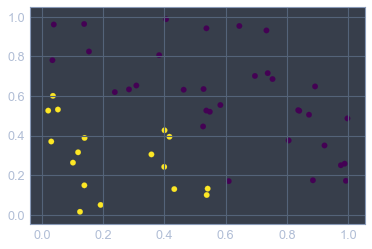

In [176]:
plt.scatter(X_test[:,0], X_test[:,1], c=y_test)

In [177]:
X[0,].reshape(-1,1)

array([[0.29624916],
       [0.80906772]])

In [178]:
X.shape

(75, 2)

In [179]:
xx, yy = np.mgrid[0:1.1:.1, 0:1.1:.1]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = net.bulk_predict(grid.T).reshape(xx.shape)

[(0, 1), Text(0,0.5,'$X_2$'), (0, 1), Text(0.5,0,'$X_1$'), None]

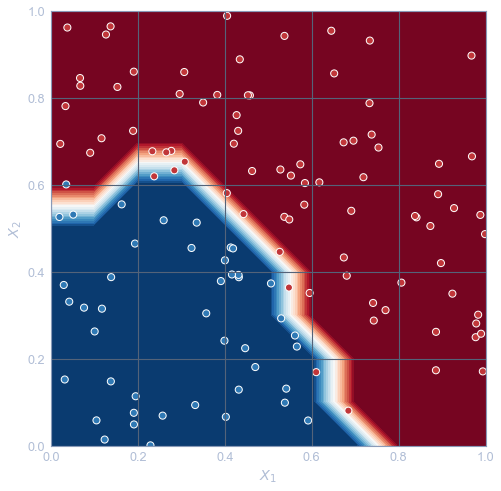

In [180]:
f , ax = plt.subplots(figsize=(8, 8))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
#ax_c = f.colorbar(contour)
#ax_c.set_label("$P(y = 1)$")
#ax_c.set_ticks([0,  1])


ax.scatter(X[:,0], X[:, 1], c=y, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.scatter(X_test[:,0], X_test[:, 1], c=y_test, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal",
       xlim=(0, 1), ylim=(0, 1),
       xlabel="$X_1$", ylabel="$X_2$")

In [183]:
u,v= net.w.values[:,0].flatten()[:2], net.w.values[:,0].flatten()[2:]
#rectangle_plot(u,v)

In [184]:
net.w

,W0,W1,W2,W3,W4,W5,W6,W7
0,0.673810,0.031988,0.021702,0.162918,0.189240,0.561349,0.547516,0.529631
1,0.080791,0.001008,0.673856,0.513222,0.532802,0.058183,0.351431,0.293031
2,0.012309,0.493783,0.873215,0.664554,0.309140,0.408419,0.404805,0.470369
3,0.102691,0.534972,0.054265,0.444841,0.111306,0.746411,0.636109,0.706969


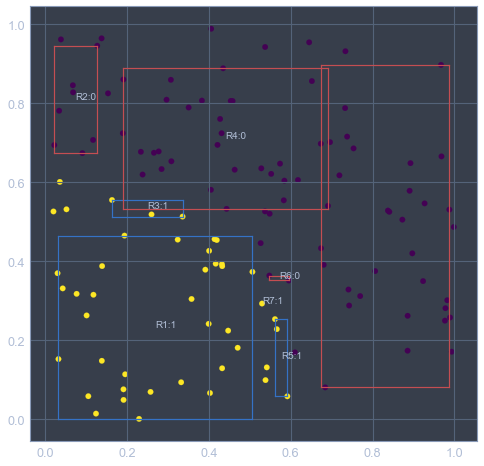

In [185]:
plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], c=y)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test)
for i in range(net.w.values.shape[1]):
    #print(i)
    u,v= net.w.values[:,i].flatten()[:2], net.w.values[:,i].flatten()[2:]
    rectangle_plot(u,v, i, net.w_labels["W{}".format(i)])
    

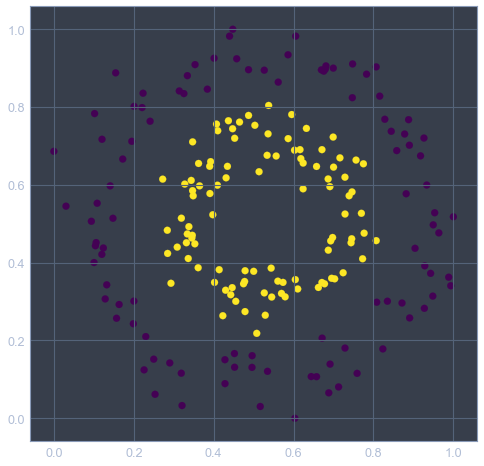

In [186]:
from sklearn.preprocessing import MinMaxScaler
plt.figure(figsize=(8,8))
X, y = make_circles(200, factor=.5, noise=.1)
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
#X = (X+1)/2
#X = scaler.f
#X = (X + np.min(X))/ np.max(X)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, )

In [187]:
np.max(X)

1.0

In [188]:
tmp_net = FuzzyARTMAP(alpha = .1, beta=1, )
tmp_net.train(X.T, y, epochs=10, )

[[0.948517  ]
 [0.31404827]
 [0.051483  ]
 [0.68595173]]


/Users/kbernardini/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:107: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [189]:
tmp_net.w

,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9
0,0.000000e+00,0.283960,0.128480,0.669662,0.272385,0.604419,0.093863,0.154653,0.808088,0.331312
1,4.003292e-01,0.263623,0.000000,0.340648,0.218302,0.332398,0.142237,0.763527,0.178510,0.575670
2,1.932576e-01,0.243645,0.051483,0.000000,0.382240,0.193102,0.571831,0.394731,0.006593,0.397837
3,2.220446e-16,0.195882,0.685952,0.089181,0.235330,0.254958,0.200187,0.000010,0.608204,0.195882


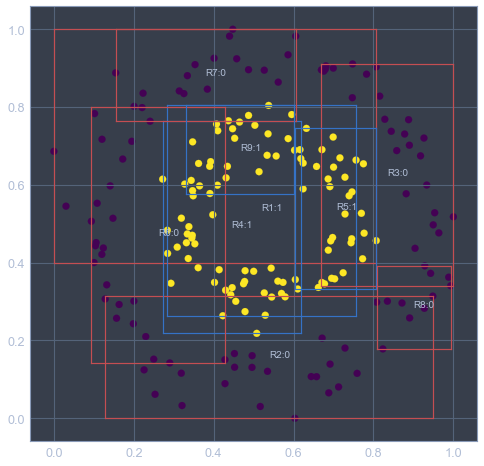

In [190]:
plt.figure(figsize=(8,8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, )
for i in range(tmp_net.w.values.shape[1]):
    #print(i)
    u,v= tmp_net.w.values[:,i].flatten()[:2], tmp_net.w.values[:,i].flatten()[2:]
    rectangle_plot(u,v, i, tmp_net.w_labels["W{}".format(i)])

In [191]:
#tmp_net.w_labels


In [192]:
np.sum((tmp_net.bulk_predict(X.T) ==y))/len(y)

1.0

In [193]:
np.sum(y ^ tmp_net.bulk_predict(X.T))/len(y)

0.0

In [194]:
xx, yy = np.mgrid[0:1.1:.1, 0:1.1:.1]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = tmp_net.bulk_predict(grid.T).reshape(xx.shape)

[(0, 1), Text(0,0.5,'$X_2$'), (0, 1), Text(0.5,0,'$X_1$'), None]

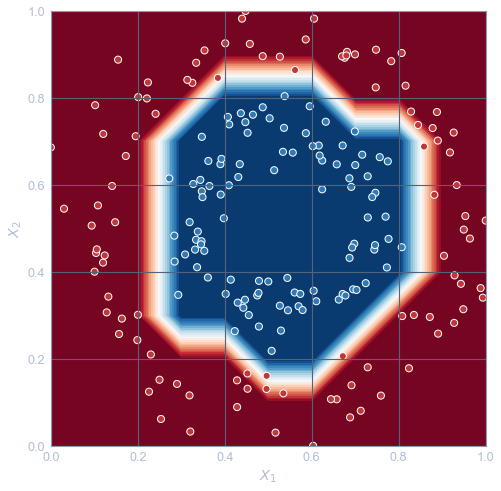

In [195]:
f , ax = plt.subplots(figsize=(8, 8))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
#ax_c = f.colorbar(contour)
#ax_c.set_label("$P(y = 1)$")
#ax_c.set_ticks([0,  1])


ax.scatter(X[:,0], X[:, 1], c=y, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal",
       xlim=(0, 1), ylim=(0, 1),
       xlabel="$X_1$", ylabel="$X_2$")

In [196]:
ker_map = lambda X: np.exp(- ( (X[:,0] - X[:,1])**2  ))
kernel_X = ker_map(X)

In [197]:
kernel_X

array([0.66861253, 0.93940565, 0.99      , 0.97493949, 0.91960608,
       0.89125245, 0.79260415, 0.94718163, 0.78936729, 0.87449205,
       0.91257302, 0.99092464, 0.68728293, 0.66086126, 0.91132257,
       0.91561392, 0.91788112, 0.91404352, 0.99448038, 0.99448822,
       0.70046916, 0.97853352, 0.93087201, 0.95905711, 0.62862153,
       0.89359838, 0.94688779, 0.97637298, 0.88520617, 0.84244899,
       0.96465474, 0.98064155, 0.9826001 , 0.65303993, 0.9914546 ,
       0.88811032, 0.98968047, 0.97147024, 0.67021468, 0.87669225,
       0.7888031 , 0.99805996, 0.6244491 , 0.96564366, 0.75948422,
       0.95960754, 0.80443036, 0.89362257, 0.99782873, 0.77116933,
       0.95843164, 0.96871063, 0.73424041, 0.72215422, 0.7609482 ,
       0.98553387, 0.74039959, 0.98622933, 0.98349868, 0.89746752,
       0.9898667 , 0.91576083, 0.95657182, 0.93714577, 0.9799698 ,
       0.96270135, 0.98977038, 0.91347374, 0.98439856, 0.91872865,
       0.98514359, 0.77161105, 0.8751857 , 0.96559905, 0.97838

In [198]:
X_tr = np.hstack((X,kernel_X.reshape(-1,1)))
X_tr

array([[0.948517  , 0.31404827, 0.66861253],
       [0.5031052 , 0.75312099, 0.93940565],
       [0.15683455, 0.25708591, 0.99      ],
       [0.42293385, 0.26362322, 0.97493949],
       [0.50780121, 0.21830185, 0.91960608],
       [0.42837352, 0.089069  , 0.89125245],
       [1.        , 0.51788864, 0.79260415],
       [0.69767902, 0.4647318 , 0.94718163],
       [0.51661667, 0.0302798 , 0.78936729],
       [0.14789614, 0.51410929, 0.87449205],
       [0.56159514, 0.86406361, 0.91257302],
       [0.69086683, 0.59538496, 0.99092464],
       [0.2232148 , 0.83559479, 0.68728293],
       [0.75902838, 0.11543585, 0.66086126],
       [0.88185762, 0.57713093, 0.91132257],
       [0.44734694, 0.74426525, 0.91561392],
       [0.74387263, 0.45114853, 0.91788112],
       [0.10053411, 0.4003292 , 0.91404352],
       [0.61613981, 0.6905368 , 0.99448038],
       [0.33632479, 0.41066878, 0.99448822],
       [0.12051214, 0.71717364, 0.70046916],
       [0.87800058, 0.73069058, 0.97853352],
       [0.

In [209]:
ker_net = FuzzyARTMAP(alpha=.1, rho=.1)
ker_net.train(X_tr.T, y, epochs=1)

[[0.948517  ]
 [0.31404827]
 [0.66861253]
 [0.051483  ]
 [0.68595173]
 [0.33138747]]


/Users/kbernardini/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:107: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [210]:
np.sum((ker_net.bulk_predict(X_tr.T) == y))/len(y)

1.0

In [211]:
xx, yy = np.mgrid[0:1.1:.1, 0:1.1:.1]
grid = np.c_[xx.ravel(), yy.ravel()]
grid = np.hstack((grid,ker_map(grid).reshape(-1,1)))
probs = ker_net.bulk_predict(grid.T).reshape(xx.shape)

[(0, 1), Text(0,0.5,'$X_2$'), (0, 1), Text(0.5,0,'$X_1$'), None]

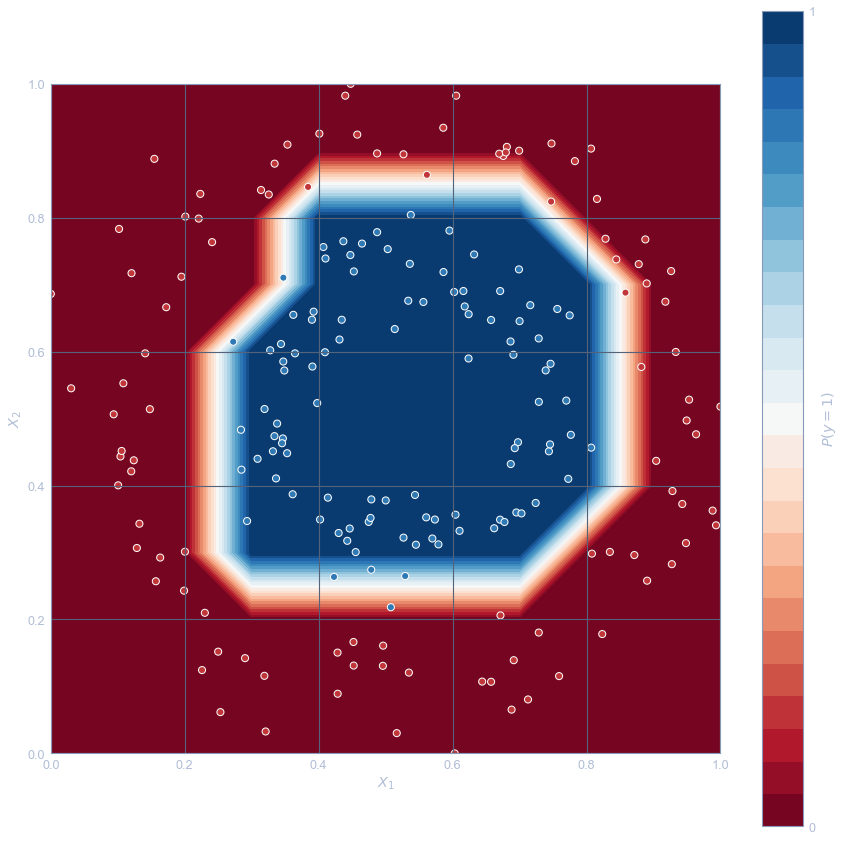

In [212]:

f , ax = plt.subplots(figsize=(15, 15))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0,  1])


ax.scatter(X[:,0], X[:, 1], c=y, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal",
       xlim=(0, 1), ylim=(0, 1),
       xlabel="$X_1$", ylabel="$X_2$")

In [68]:
def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) #+ np.random.randn(N)*0.1 # theta
        r = a*np.sin(4*t) #+ np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    return X, Y



In [130]:
p_X, p_y = load_planar_dataset()
scale_planar = MinMaxScaler()
scale_planar.fit(p_X)
p_X = scale_planar.transform(p_X)

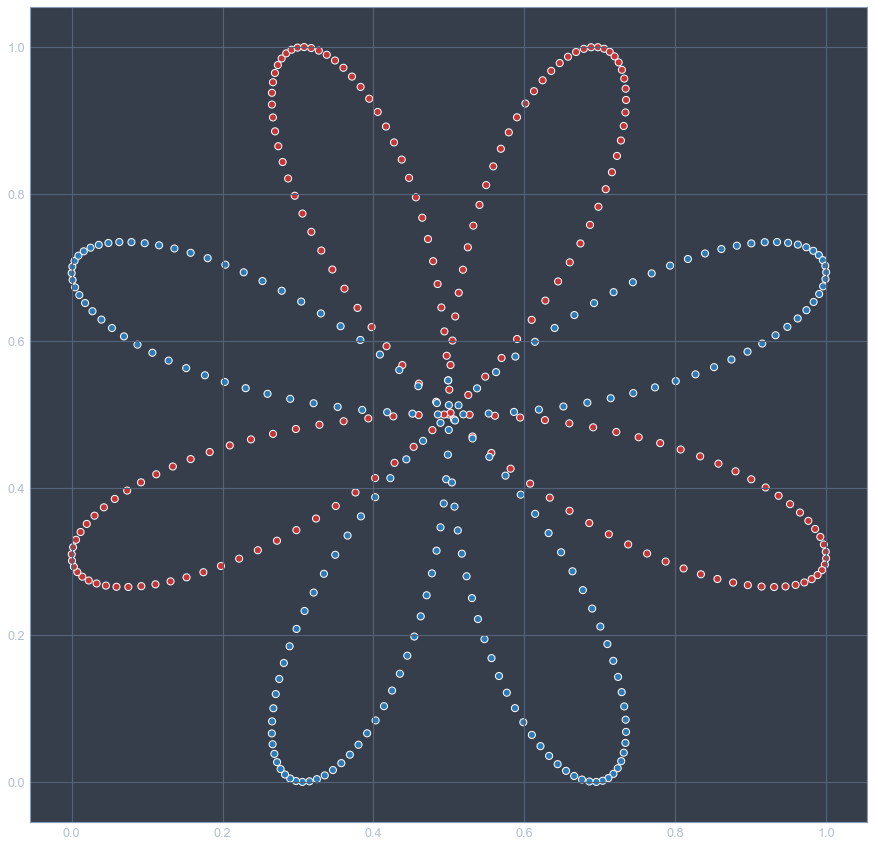

In [131]:
f, ax = plt.subplots(figsize=(15, 15))
ax.scatter(p_X[:,0], p_X[:, 1], c=p_y.flatten(), s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

In [264]:
planar_net = FuzzyARTMAP(alpha=.1, rho=.95)
planar_net.train(p_X.T, p_y, epochs = 1)


[[0.49999832]
 [0.50000314]
 [0.50000168]
 [0.49999686]]


/Users/kbernardini/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:107: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [265]:
print( np.sum((planar_net.bulk_predict(p_X.T ) == p_y.flatten()))/len(p_y.flatten()))

0.9875


In [266]:
xx, yy = np.mgrid[0:1.1:.1, 0:1.1:.1]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = planar_net.bulk_predict(grid.T).reshape(xx.shape)

[(0, 1), Text(0,0.5,'$X_2$'), (0, 1), Text(0.5,0,'$X_1$'), None]

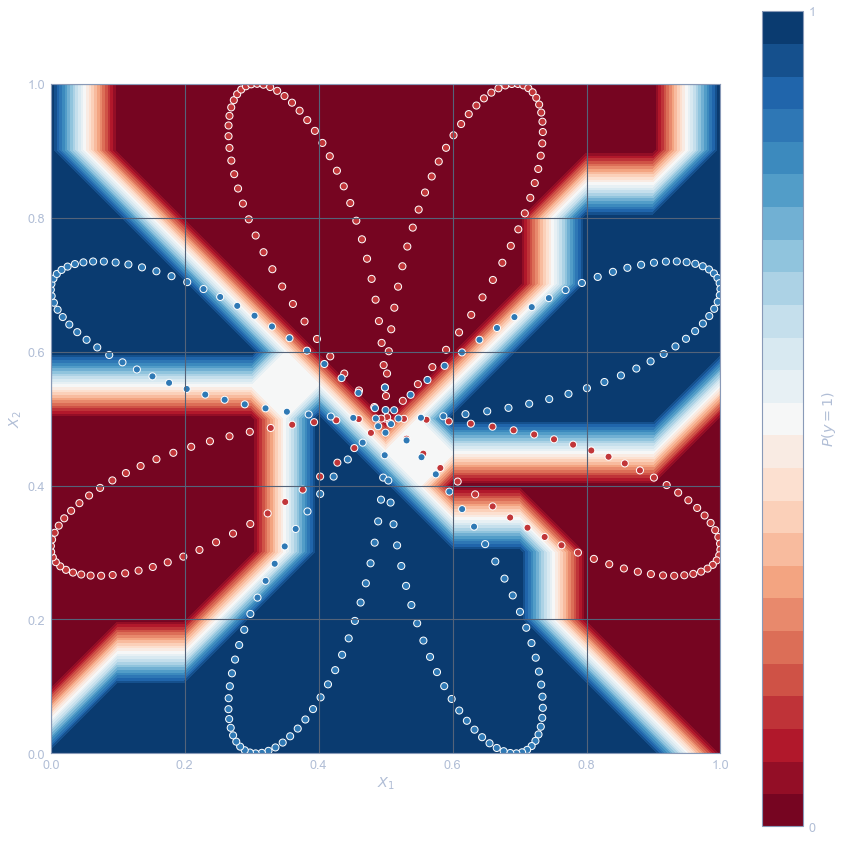

In [267]:

f, ax = plt.subplots(figsize=(15, 15))


contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0,  1])

ax.scatter(p_X[:,0], p_X[:, 1], c=p_y.flatten(), s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal",
       xlim=(0, 1), ylim=(0, 1),
       xlabel="$X_1$", ylabel="$X_2$")

In [272]:
p_X_tr = np.hstack((p_X,ker_map(p_X).reshape(-1,1)))
tr_planar_net = FuzzyARTMAP(alpha=.1, rho=.95)
tr_planar_net.train(p_X_tr.T, p_y, epochs = 1)

[[4.99998316e-01]
 [5.00003145e-01]
 [1.00000000e+00]
 [5.00001684e-01]
 [4.99996855e-01]
 [4.66322536e-11]]


/Users/kbernardini/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:107: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


[(0, 1), Text(0,0.5,'$X_2$'), (0, 1), Text(0.5,0,'$X_1$'), None]

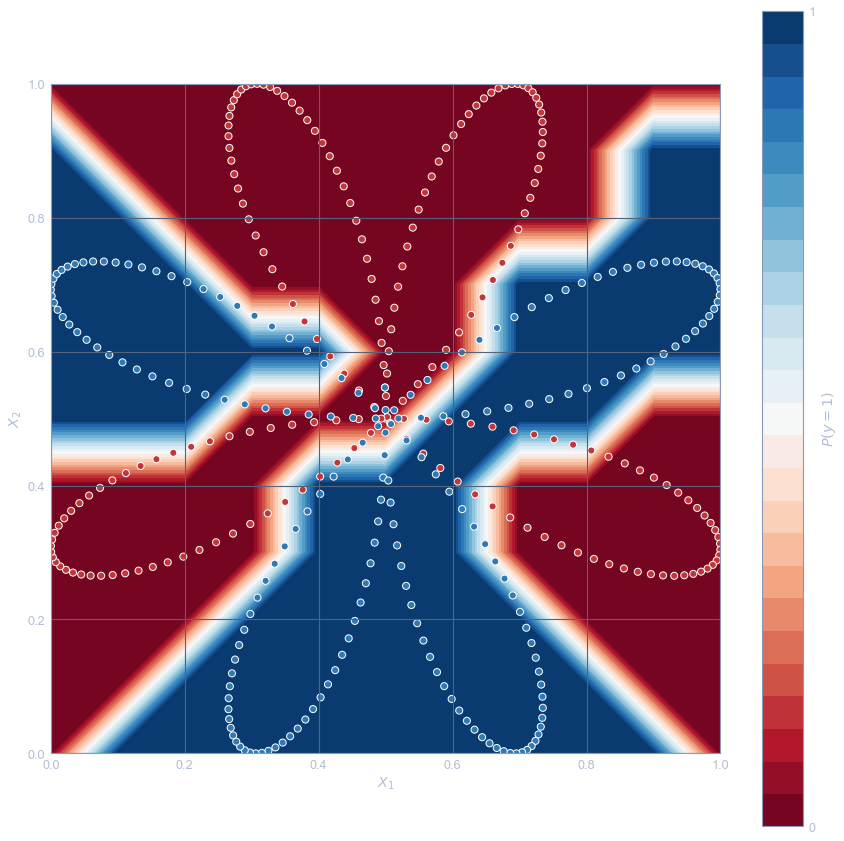

In [273]:
xx, yy = np.mgrid[0:1.1:.1, 0:1.1:.1]
grid = np.c_[xx.ravel(), yy.ravel()]
grid = np.hstack((grid, ker_map(grid).reshape(-1,1)))
probs = tr_planar_net.bulk_predict(grid.T).reshape(xx.shape)
f, ax = plt.subplots(figsize=(15, 15))


contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0,  1])

ax.scatter(p_X[:,0], p_X[:, 1], c=p_y.flatten(), s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal",
       xlim=(0, 1), ylim=(0, 1),
       xlabel="$X_1$", ylabel="$X_2$")

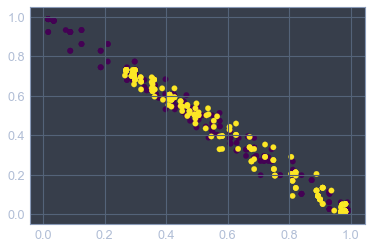

In [274]:
tr_pp_X = planar_net.bulk_transform(p_X.T).reshape((2, p_X.shape[0])).T

plt.scatter(tr_pp_X[:,0], tr_pp_X[:,1], c=p_y.flatten())

In [275]:
print( np.sum((tr_planar_net.bulk_predict(p_X_tr.T ) == p_y.flatten()))/len(p_y.flatten()))

0.9775


In [78]:

def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))



In [79]:
spiral_X, spiral_y = twospirals(500)
scale_spiral = MinMaxScaler()
scale_spiral.fit(spiral_X)
spiral_X = scale_spiral.transform(spiral_X)

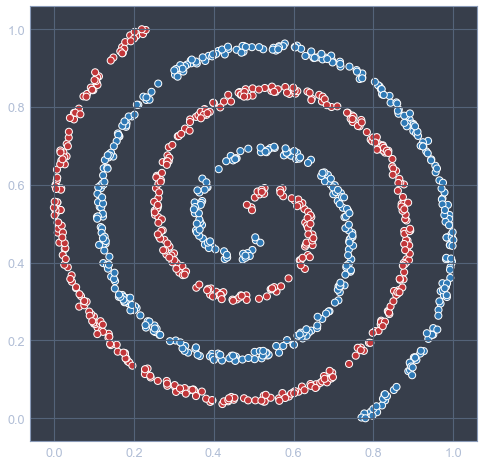

In [213]:

f, ax = plt.subplots(figsize=(8, 8))
ax.scatter(spiral_X[:,0], spiral_X[:, 1], c=spiral_y.flatten(), s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

In [250]:
net = FuzzyARTMAP(alpha=0.1, rho=.9, norm=1)
net.train(spiral_X.T,spiral_y.astype(int), epochs=1)

[[0.5895137 ]
 [0.83377602]
 [0.4104863 ]
 [0.16622398]]


/Users/kbernardini/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:107: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [251]:
preds =  net.bulk_predict(spiral_X.T)
sum(preds == spiral_y) / len(spiral_y)

1.0

In [252]:
xx, yy = np.mgrid[0:1.1:.1, 0:1.1:.1]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = net.bulk_predict(grid.T).reshape(xx.shape)
#t_grid.shape, grid.shape

[(0, 1), Text(0,0.5,'$X_2$'), (0, 1), Text(0.5,0,'$X_1$'), None]

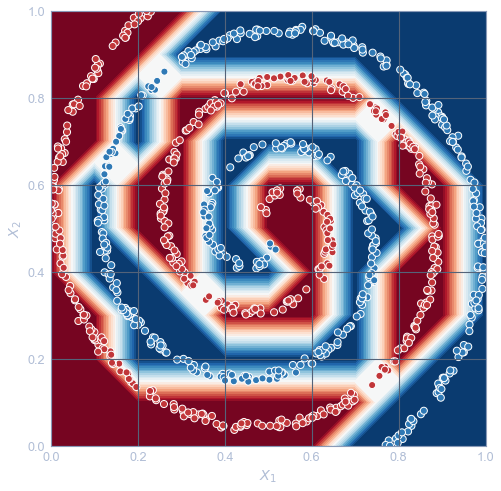

In [253]:
f, ax = plt.subplots(figsize=(8, 8))


contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
#ax_c = f.colorbar(contour)
#ax_c.set_label("$P(y = 1)$")
#ax_c.set_ticks([0,  1])
ax.scatter(spiral_X[:,0], spiral_X[:, 1], c=spiral_y.flatten(), s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal",
       xlim=(0, 1), ylim=(0, 1),
       xlabel="$X_1$", ylabel="$X_2$")

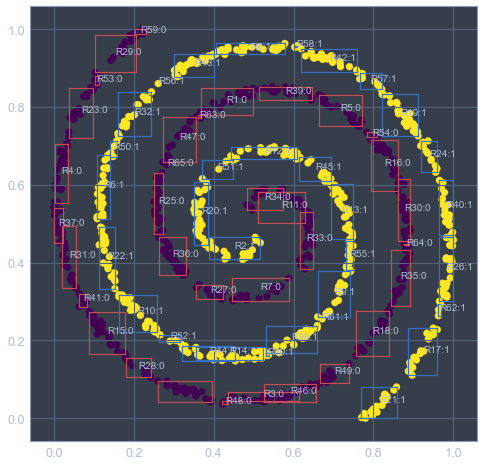

In [254]:
plt.figure(figsize=(8,8))
plt.scatter(spiral_X[:, 0], spiral_X[:, 1], c=spiral_y, s=50, )
for i in range(net.w.values.shape[1]):
    #print(i)
    u,v= net.w.values[:,i].flatten()[:2],net.w.values[:,i].flatten()[2:]
    rectangle_plot(u,v, i, net.w_labels["W{}".format(i)])

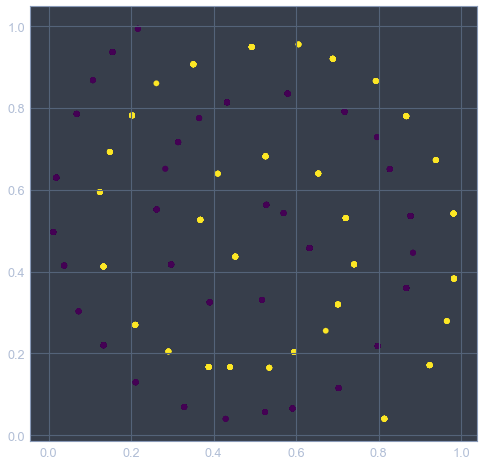

In [255]:
plt.figure(figsize=(8,8))
spiral_tr_x = net.bulk_transform(spiral_X.T)
plt.scatter(spiral_tr_x[:,0], spiral_tr_x[:,1], c=spiral_y)

In [256]:
ker_map = lambda X: np.exp(-2 *( (X[:,0] - X[:,1])**2  ))

spiral_tr_X = np.hstack((spiral_X,ker_map(spiral_X).reshape(-1,1)))
spiral_tr_X


array([[0.5895137 , 0.83377602, 0.88751651],
       [0.00538635, 0.52787709, 0.5792662 ],
       [0.2873904 , 0.44076589, 0.95404152],
       ...,
       [0.30142166, 0.89424973, 0.49515213],
       [0.13489554, 0.67629054, 0.55642823],
       [0.39844921, 0.93561349, 0.56152953]])

In [257]:
ker_net = FuzzyARTMAP(alpha=0.1, rho=0, norm=1)
ker_net.train(spiral_tr_X.T,spiral_y.astype(int), epochs=1)

[[0.5895137 ]
 [0.83377602]
 [0.88751651]
 [0.4104863 ]
 [0.16622398]
 [0.11248349]]


/Users/kbernardini/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:107: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [258]:
np.sum( (ker_net.bulk_predict(spiral_tr_X.T) == spiral_y))/len(spiral_y)

0.948

[(0, 1), Text(0,0.5,'$X_2$'), (0, 1), Text(0.5,0,'$X_1$'), None]

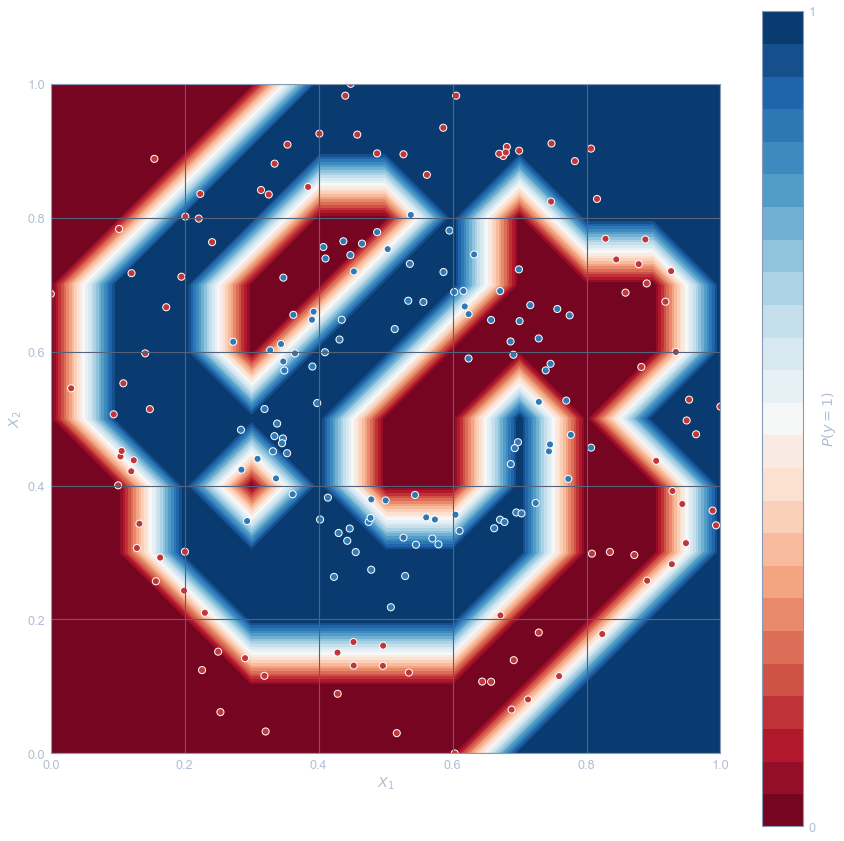

In [259]:
xx, yy = np.mgrid[0:1.1:.1, 0:1.1:.1]
grid = np.c_[xx.ravel(), yy.ravel()]
grid = np.hstack((grid,ker_map(grid).reshape(-1,1)))
probs = ker_net.bulk_predict(grid.T).reshape(xx.shape)
f , ax = plt.subplots(figsize=(15, 15))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0,  1])


ax.scatter(X[:,0], X[:, 1], c=y, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal",
       xlim=(0, 1), ylim=(0, 1),
       xlabel="$X_1$", ylabel="$X_2$")

In [361]:
import sklearn.datasets as ds
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

iris = ds.load_iris()
iris_X = iris['data'] 
iris_y = iris['target']


In [362]:
iris_scale = MinMaxScaler()
iris_scale.fit(iris_X)
iris_X = iris_scale.transform(iris_X)

In [363]:
X_train, X_test, y_train, y_test = train_test_split(
     iris_X, iris_y, test_size=0.33, random_state=42)

In [364]:
iris_net = FuzzyARTMAP(alpha=.1, rho=.6)
iris_net.train(X_train.T, y_train)

[[0.38888889]
 [0.375     ]
 [0.54237288]
 [0.5       ]
 [0.61111111]
 [0.625     ]
 [0.45762712]
 [0.5       ]]


/Users/kbernardini/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:107: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [365]:
np.sum((iris_net.bulk_predict(X_train.T) == y_train))/len(y_train)

0.95

In [366]:
iris_art_score = np.sum((iris_net.bulk_predict(X_test.T) == y_test))/len(y_test)

In [382]:
iris_lr = LogisticRegression()
iris_lr.fit(X_train, y_train)
iris_lr_score = iris_lr.score(X_test, y_test)
iris_svm= SVC()
iris_svm.fit(X_train, y_train)
iris_svm_score = iris_svm.score(X_test, y_test)

iris_tree = DecisionTreeClassifier(random_state=42)
iris_tree.fit(X_train, y_train)
iris_tree_score = iris_tree.score(X_test, y_test)

iris_mlp = MLPClassifier(solver='adam', alpha=1e-5,
                    hidden_layer_sizes=(5,5,5), max_iter=1000,random_state=1)
iris_mlp.fit(X_train, y_train)

iris_mlp_score = iris_mlp.score(X_test, y_test)

In [383]:
iris_scores = [iris_art_score, iris_lr_score, iris_svm_score, iris_tree_score, iris_mlp_score]
iris_scores

[0.96, 0.84, 0.98, 0.98, 0.96]

In [384]:

y_test

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0,
       0, 1, 2, 2, 1, 2])

In [295]:
from mlxtend.evaluate import confusion_matrix

In [296]:
iris_preds = iris_net.bulk_predict(X_test.T)
cm = confusion_matrix(y_target=y_test, 
                      y_predicted=iris_preds, 
                      binary=False)

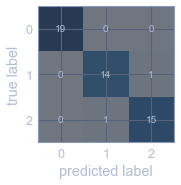

In [298]:
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=cm)

In [385]:
from sklearn.datasets import load_breast_cancer
bc = load_breast_cancer()
X_bc = bc['data']
y_bc = bc['target']

In [386]:
x_mms = MinMaxScaler()
x_mms.fit(X_bc)
X_bc =x_mms.transform(X_bc)

In [387]:
Xbc_train, Xbc_test, ybc_train, ybc_test = train_test_split(
     X_bc, y_bc ,test_size=0.33, random_state=42)

In [388]:
bc_net = FuzzyARTMAP(alpha=.1, rho=.8)
bc_net.train(Xbc_train.T, ybc_train)

[[0.4012968 ]
 [0.07372337]
 [0.40570797]
 [0.25170732]
 [0.65965514]
 [0.4175204 ]
 [0.47610122]
 [0.54522863]
 [0.45757576]
 [0.43660489]
 [0.11204056]
 [0.06588136]
 [0.09649908]
 [0.07067266]
 [0.12509773]
 [0.15740379]
 [0.10866162]
 [0.25004736]
 [0.141245  ]
 [0.11308265]
 [0.38633938]
 [0.13379531]
 [0.37148264]
 [0.22532442]
 [0.54104207]
 [0.32114756]
 [0.46565495]
 [0.62783505]
 [0.32544845]
 [0.30145612]
 [0.5987032 ]
 [0.92627663]
 [0.59429203]
 [0.74829268]
 [0.34034486]
 [0.5824796 ]
 [0.52389878]
 [0.45477137]
 [0.54242424]
 [0.56339511]
 [0.88795944]
 [0.93411864]
 [0.90350092]
 [0.92932734]
 [0.87490227]
 [0.84259621]
 [0.89133838]
 [0.74995264]
 [0.858755  ]
 [0.88691735]
 [0.61366062]
 [0.86620469]
 [0.62851736]
 [0.77467558]
 [0.45895793]
 [0.67885244]
 [0.53434505]
 [0.37216495]
 [0.67455155]
 [0.69854388]]


/Users/kbernardini/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:107: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [389]:

bc_clf = LogisticRegression()
bc_clf.fit(X=Xbc_train, y=ybc_train)
bc_lr_score = bc_clf.score(Xbc_test, ybc_test)

In [390]:

bc_svm = SVC()
bc_svm.fit(X=Xbc_train, y=ybc_train)
svm_score = bc_svm.score(Xbc_test, ybc_test)

In [391]:

tree_bc = DecisionTreeClassifier(random_state=42)
tree_bc.fit(X=Xbc_train, y=ybc_train)
tree_score= tree_bc.score(Xbc_test, ybc_test)
tree_score

0.9202127659574468

In [392]:
np.sum((bc_net.bulk_predict(Xbc_train.T) == ybc_train))/len(ybc_train)

0.9973753280839895

In [393]:
art_score_bc = np.sum((bc_net.bulk_predict(Xbc_test.T) == ybc_test))/len(ybc_test)
art_score_bc

0.9574468085106383

In [395]:
bc_mlp = MLPClassifier(solver='adam', alpha=1e-5,
                    hidden_layer_sizes=(5,5,5), max_iter=1000,random_state=1)
bc_mlp.fit(X=Xbc_train, y=ybc_train)
mlp_bc_score = bc_mlp.score(Xbc_test, ybc_test)
mlp_bc_score

0.9787234042553191

In [397]:
["Fuzzy ARTMap", 'Logistic Regression', 'Linear SVM', 'CART', 'Tuned MLP']
scores = [art_score_bc, bc_lr_score, svm_score, tree_score, mlp_bc_score]
score_df = pd.DataFrame(scores, ["Fuzzy ARTMap", 'Logistic Regression', 'Linear SVM', 'CART', 'Tuned MLP'], columns=['Breast Cancer'])
score_df['Iris'] = iris_scores
print(score_df.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Breast Cancer &  Iris \\
\midrule
Fuzzy ARTMap        &       0.957447 &  0.96 \\
Logistic Regression &       0.952128 &  0.84 \\
Linear SVM          &       0.957447 &  0.98 \\
CART                &       0.920213 &  0.98 \\
Tuned MLP           &       0.978723 &  0.96 \\
\bottomrule
\end{tabular}



In [359]:
#l1_norm = partial(np.linalg.norm, ord=1, axis=-1)

from sklearn.metrics.pairwise import laplacian_kernel
class KernelARTMAP:
    def __init__(self,  alpha=0.01, beta=1.0, rho=0., epsilon=.00001, complement_coding=True):
        """
        alpha: matching parameter
        beta: learning rate
        rho: Vigilence criterion

        """
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.epsilon=epsilon
        self.complement_coding= complement_coding
        self.w = None
        self.w_labels = {}
        # there are no commited nodes
        self.C= -1
        self.M = None
    
    def add_category(self,x, y_label):
        """Adds an additional weight vectot w of class y """# 
        # use the weight as the examplar 
        self.C +=1
        print("The input x to category ", x)
        self.w["W{}".format(self.C)]  =  x
        # save category label 
        self.w_labels["W{}".format(self.C)] = np.squeeze(y_label)
        
    def match_choice(self, x, f=laplacian_kernel):
        # size of the w matrix using Linear dot product
        norm_w =  np.linalg.norm( self.w, ord=1, axis=0)
        norm_x = np.linalg.norm( x, ord=1, axis=0) 
        # TODO: Hacky as hell, fix this later 
        inner_prod =  1- f(self.w.T ,x.T).T
        # all values of T_j for j=1,...,C
        T_js = inner_prod / (self.alpha * np.exp(- norm_w))
        vig_val = inner_prod/ np.exp(- norm_x)
        #print( "Vigilance: ", vig_val, self.rho)
        vig = vig_val >= self.rho
        #print("Bool vig:", vig)
        indicies = sorted(range(len(T_js)), key=lambda k: T_js[k], reverse=True)
        return T_js, vig.flatten(), vig_val, indicies, inner_prod, norm_w
                          
                          
    
    
    def train(self, X, y, epochs = 1):
        """number of examples x number of features"""
        # initialize first weight 
        self.C = 0
        x_init = X[:,0].reshape(-1,1)
        self.M = np.squeeze(X.shape[0])
        print(x_init)
        self.w = pd.DataFrame(np.ones( ( x_init.shape[0],1)), columns=["W{}".format(self.C)])
        # initialize first class
        self.w_labels["W{}".format(self.C)] = np.squeeze(y[0])
        print(self.w, self.w_labels, X)
        for epoch in range(epochs):
            for i in range(X.shape[1]):
                # evaulate match criterion with choice function 
                # T_j is the array of activations
                # vig is a  boolean array determining if the input satisfies the vigilence parameter
                # indicies is the sorted array of indicies
                # fuzzy int is the fuzzy intersection
                #norm_w is the norm o the weight vectors 
                satisfied = False
                # we will go until we are satisfied with a prediction 
                attempts = 0
                self.rho = 0
                A = X[:,i].reshape(-1,1)
                while not satisfied:
                    attempts +=1
                    print("Attempts: {}".format(attempts))
                    T_js, vig, vig_val,  indicies, inner_prod, norm_w = self.match_choice(A)
                    
                    look= True
                    ind = -1
                    while ind < len(list(indicies)) and look:
                        ind +=1
                        index = indicies[ind]
                        if vig[index]:
                            # we have satisfied the vigilence criterion 
                            pred = self.w_labels["W{}".format(index)]
                            if pred != y[i]:
                                # Match tracking for incorrect predictions 
                                self.rho = (vig_val.flatten()[index]) + self.epsilon
                                print("Wrong Prediction {}, for ground truth {}. Match tracking enabled with rho {}.".format(pred, y[i], self.rho))
                                
                                look=False
                                # we are still not satisfied 
                            else: 
                                # Resonance enabled 
                                print(" Prediction {}, for ground truth {}. Resonance enabled.".format(pred, y[i]))
                                w_old = self.w["W{}".format(index)].reshape(-1,1)
                                #print("DEBUG:",A.shape, w_old.shape )
                                new_comp =   (w_old - A) #inner_prod[index] * 
                                self.w["W{}".format(index)] = self.beta * ( new_comp) + (1- self.beta)*w_old
                                look = False
                                satisfied = True
                                print("Updated weight  ", self.w["W{}".format(index)])
                        if ind == len(list(indicies)) -1 and look: 
                            print("No node found that satisfies Vigilence criterion. Creating a new node")
                            self.add_category( np.exp(-A), y[i])
                            satisfied=True
                            look=False
                            continue
                            
                                
                
                
                
    def bulk_predict(self, X):
        rets = []
        for i in range(X.shape[1]):
            A =X[:,i].reshape(-1,1)
            rets +=[self.predict(A)]
        return np.array(rets)
            
    def predict(self, x, f=laplacian_kernel):
        norm_w =  np.linalg.norm( self.w, ord=1, axis=0)
        norm_x = np.linalg.norm( x, ord=1, axis=0) 
        # TODO: Hacky as hell, fix this later 
        inner_prod =  1- f(self.w.T ,x.T).T
        # all values of T_j for j=1,...,C
        T_js = inner_prod / (self.alpha * np.exp(- norm_w))
        weight_index = np.argmax(   T_js )
        return self.w_labels["W{}".format(weight_index)]
        
        
        

SyntaxError: invalid syntax (<ipython-input-359-129453ece25c>, line 1)

In [91]:
ker_net = KernelARTMAP(beta=1)

In [92]:
ker_net.train(X_test.T, y_test, epochs=2)

[[0.02964915]
 [0.52413187]]
    W0
0  1.0
1  1.0 {'W0': 1} [[0.02964915 0.01112112 0.38782083 0.06789638 0.71313437 0.78500251
  0.01612591 0.10624545 0.90496301 0.99583667 0.77274671 0.98167437
  0.32101936 0.28653433 0.91889766 0.84763211 0.81201504 0.49516615
  0.29993128 0.7249896  0.68158538 0.08716982 0.33825589 0.43067483
  0.48463751 0.52531984 0.71566197 0.42653952 0.52649416 0.8068269
  0.39395707 0.53161194 0.44594027 0.52844957 0.52615854 0.31529659
  0.01436183 0.93180752 0.82523508 0.63532332 0.96447103 0.26293
  0.63186857 0.96181411 0.09918096 0.34982974 0.98870958 0.50542317
  0.68585921 0.61965255]
 [0.52413187 0.65510581 0.42166217 0.07599294 0.49643559 0.34120933
  0.61188356 0.51219904 0.05801103 0.45191649 0.47475267 0.18899697
  0.54028283 0.19783253 0.12334975 0.18270776 0.26239735 0.55944658
  0.28647718 0.10411623 0.24838758 0.09684057 0.75090644 0.34534623
  0.84085492 0.73772114 0.40032063 0.53694021 0.38270089 0.41641974
  0.05155345 0.5263457  0.83744595 

/Users/kbernardini/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:97: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


 0   -1.955474
1   -2.683996
Name: W0, dtype: float64
Attempts: 1
 Prediction 1, for ground truth 1. Resonance enabled.
Updated weight   0   -2.481633
1   -2.801527
Name: W0, dtype: float64
Attempts: 1
 Prediction 1, for ground truth 1. Resonance enabled.
Updated weight   0   -2.796929
1   -2.925291
Name: W0, dtype: float64
Attempts: 1
Wrong Prediction 1, for ground truth 0. Match tracking enabled with rho 2.0294580559725457.
Attempts: 2
No node found that satisfies Vigilence criterion. Creating a new node
The input x to category  [[0.9857408 ]
 [0.48019885]]
Attempts: 1
Wrong Prediction 1, for ground truth 0. Match tracking enabled with rho 2.860839872702956.
Attempts: 2
No node found that satisfies Vigilence criterion. Creating a new node
The input x to category  [[0.39384119]
 [0.85802343]]
Attempts: 1
Wrong Prediction 1, for ground truth 0. Match tracking enabled with rho 3.7569627110551655.
Attempts: 2
No node found that satisfies Vigilence criterion. Creating a new node
The input

Wrong Prediction 1, for ground truth 0. Match tracking enabled with rho 3.395223511627532.
Attempts: 2
No node found that satisfies Vigilence criterion. Creating a new node
The input x to category  [[0.44627189]
 [0.65940344]]
Attempts: 1
 Prediction 1, for ground truth 1. Resonance enabled.
Updated weight   0   -5.836713
1   -7.457635
Name: W0, dtype: float64
Attempts: 1
Wrong Prediction 1, for ground truth 0. Match tracking enabled with rho 2.8782895660447636.
Attempts: 2
No node found that satisfies Vigilence criterion. Creating a new node
The input x to category  [[0.58765694]
 [0.59075984]]
Attempts: 1
Wrong Prediction 1, for ground truth 0. Match tracking enabled with rho 3.6063841886997485.
Attempts: 2
No node found that satisfies Vigilence criterion. Creating a new node
The input x to category  [[0.64022201]
 [0.43281454]]
Attempts: 1
 Prediction 1, for ground truth 1. Resonance enabled.
Updated weight   0   -6.365163
1   -7.477429
Name: W0, dtype: float64
Attempts: 1
 Predicti

In [93]:
ker_net.w

,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,...,W59,W60,W61,W62,W63,W64,W65,W66,W67,W68
0,-7.819378,0.988940,0.490106,0.456119,0.404557,0.369414,0.461743,0.374683,0.398959,0.428428,...,0.438132,0.529764,0.381185,0.531598,0.382199,0.905579,0.372056,0.603250,0.503657,0.538131
1,-8.586865,0.519387,0.608696,0.710910,0.943640,0.636407,0.622039,0.827789,0.883954,0.833012,...,0.589851,0.871613,0.904127,0.962692,0.583796,0.397154,0.417788,0.470731,0.788472,0.370335


In [94]:
ker_net.bulk_predict(X_test.T)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [95]:
ker_net.w_labels

{'W0': 1,
 'W1': 0,
 'W2': 0,
 'W3': 0,
 'W4': 0,
 'W5': 0,
 'W6': 0,
 'W7': 0,
 'W8': 0,
 'W9': 0,
 'W10': 0,
 'W11': 0,
 'W12': 0,
 'W13': 0,
 'W14': 0,
 'W15': 0,
 'W16': 0,
 'W17': 0,
 'W18': 0,
 'W19': 0,
 'W20': 0,
 'W21': 0,
 'W22': 0,
 'W23': 0,
 'W24': 0,
 'W25': 0,
 'W26': 0,
 'W27': 0,
 'W28': 0,
 'W29': 0,
 'W30': 0,
 'W31': 0,
 'W32': 0,
 'W33': 0,
 'W34': 0,
 'W35': 0,
 'W36': 0,
 'W37': 0,
 'W38': 0,
 'W39': 0,
 'W40': 0,
 'W41': 0,
 'W42': 0,
 'W43': 0,
 'W44': 0,
 'W45': 0,
 'W46': 0,
 'W47': 0,
 'W48': 0,
 'W49': 0,
 'W50': 0,
 'W51': 0,
 'W52': 0,
 'W53': 0,
 'W54': 0,
 'W55': 0,
 'W56': 0,
 'W57': 0,
 'W58': 0,
 'W59': 0,
 'W60': 0,
 'W61': 0,
 'W62': 0,
 'W63': 0,
 'W64': 0,
 'W65': 0,
 'W66': 0,
 'W67': 0,
 'W68': 0}

In [96]:
y_test

array([1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0])

In [97]:
y_test

array([1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0])